In [291]:
import numpy as np
import pandas as pd
from rdkit.Chem import Descriptors
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import defaultdict
from matplotlib import pyplot as plt
import json
import seaborn as sns

import sklearn
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

plt.style.use('ggplot')

In [292]:
data = pd.read_csv('activity_data.csv')

In [62]:
data.head(5)

SMILES                  CID  \
0  CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...  LUO-POS-e1dab717-11   
1  O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...  LUO-POS-e1dab717-12   
2  CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...   MAT-POS-e48723dc-1   
3  CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...   MAT-POS-e48723dc-2   
4  CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...   LUO-POS-9931618f-2   

         canonical_CID  r_inhibition_at_20_uM  r_inhibition_at_50_uM  \
0  LUO-POS-e1dab717-11                    NaN                    NaN   
1  LUO-POS-e1dab717-12                    NaN                    NaN   
2   MAT-POS-e48723dc-1                    NaN                    NaN   
3   MAT-POS-e48723dc-2                    NaN                    NaN   
4   LUO-POS-9931618f-2                    NaN                    NaN   

   r_avg_IC50  f_inhibition_at_20_uM  f_inhibition_at_50_uM  f_avg_IC50  \
0         NaN                    NaN                    NaN    0.275118   
1         NaN                    NaN                    NaN    0.202767   
2         NaN                    NaN                    NaN   55.453947   
3         NaN                    NaN                    NaN    0.050000   
4         NaN                    NaN                    NaN    0.052757   

   f_avg_pIC50  relative_solubility_at_20_uM  relative_solubility_at_100_uM  \
0          NaN                           NaN                            NaN   
1          NaN                           NaN                            NaN   
2          NaN                           NaN                            NaN   
3          NaN                           NaN                            NaN   
4          NaN                           NaN                            NaN   

   trypsin_IC50  NMR_std_ratio acrylamide chloroacetamide  \
0           NaN            NaN      False           False   
1           NaN            NaN      False           False   
2           NaN            NaN      False           False   
3           NaN            NaN      False           False   
4           NaN            NaN      False           False   

                 series frag_id  
0  3-aminopyridine-like     NaN  
1  3-aminopyridine-like     NaN  
2                   Ugi     NaN  
3                   Ugi     NaN  
4                   Ugi     NaN

In [63]:
list(data.columns)

['SMILES',
 'CID',
 'canonical_CID',
 'r_inhibition_at_20_uM',
 'r_inhibition_at_50_uM',
 'r_avg_IC50',
 'f_inhibition_at_20_uM',
 'f_inhibition_at_50_uM',
 'f_avg_IC50',
 'f_avg_pIC50',
 'relative_solubility_at_20_uM',
 'relative_solubility_at_100_uM',
 'trypsin_IC50',
 'NMR_std_ratio',
 'acrylamide',
 'chloroacetamide',
 'series',
 'frag_id']

In [309]:
subdata = data[['SMILES', 'CID', 'r_avg_IC50', 'f_avg_IC50', 'trypsin_IC50']]
subdata #(2062,3)

SMILES                  CID  \
0     CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...  LUO-POS-e1dab717-11   
1     O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...  LUO-POS-e1dab717-12   
2     CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...   MAT-POS-e48723dc-1   
3     CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...   MAT-POS-e48723dc-2   
4     CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...   LUO-POS-9931618f-2   
...                                                 ...                  ...   
2057                   N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1   WAR-XCH-eb7b662f-2   
2058                    N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1   DAR-DIA-23aa0b97-8   
2059               N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1  DAR-DIA-23aa0b97-11   
2060                 N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1  DAR-DIA-23aa0b97-19   
2061                      O=C(Cc1cncc2ccccc12)Nc1ccccc1  DAR-DIA-23aa0b97-20   

      r_avg_IC50  f_avg_IC50  trypsin_IC50  
0            NaN    0.275118           NaN  
1            NaN    0.202767           NaN  
2            NaN   55.453947           NaN  
3            NaN    0.050000           NaN  
4            NaN    0.052757           NaN  
...          ...         ...           ...  
2057         NaN   99.010000          99.0  
2058         NaN   54.272964          99.0  
2059         NaN   63.554925          99.0  
2060   14.641091   26.719515           NaN  
2061   45.077469   57.590417          99.0  

[2062 rows x 5 columns]

In [295]:
print(subdata['SMILES'].isnull().values.any())
print(subdata['CID'].isnull().values.any())
print(subdata['f_avg_IC50'].isnull().values.any())
print(subdata['r_avg_IC50'].isnull().values.any())
print(subdata['trypsin_IC50'].isnull().values.any())

False
False
True
True
True


In [296]:
print(subdata['f_avg_IC50'].isnull().sum())
print(subdata['r_avg_IC50'].isnull().sum())
print(subdata['trypsin_IC50'].isnull().sum())

136
1399
1931


Analysing the datasets for the three different IC50 measures we see that f_avg_IC50 has the fewest missing values (136 compared to 1399 for r and 1931 for trypsin). So we take this measure forward.
But what to do with the missing values?
Looking at the data, all cases where f is missing, r is found, and from the literature we see that these two measures should correlate.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


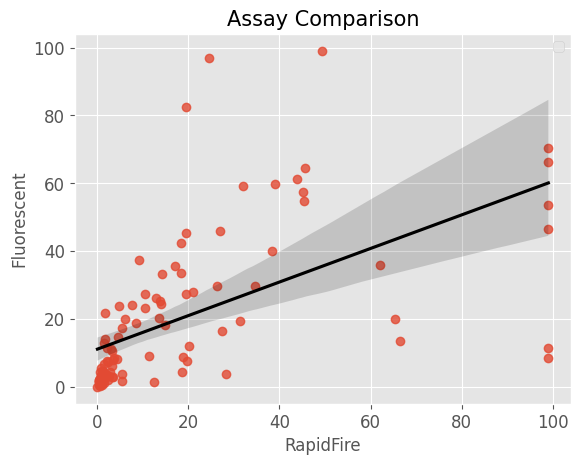

In [298]:
r_f_corr = subdata.dropna()
x = r_f_corr['r_avg_IC50']
y = r_f_corr['f_avg_IC50']
m, b = np.polyfit(x, y, 1)
#print(max(x), max(y))
#plt.scatter(x, y)
#plt.plot(x, m*x+b, color='black')
sns.regplot(x=r_f_corr['r_avg_IC50'], y=r_f_corr['f_avg_IC50'], line_kws={'color': 'black'})
plt.legend(prop={'size': 10})
plt.title('Assay Comparison', fontsize = 15)
plt.xlabel('RapidFire', fontsize = 12)
plt.ylabel('Fluorescent', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('../practical/assay_comparison.pdf')

In [34]:
is_NaN = subdata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = subdata[row_has_NaN]
rows_with_NaN

SMILES                  CID  \
0     CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...  LUO-POS-e1dab717-11   
1     O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...  LUO-POS-e1dab717-12   
2     CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...   MAT-POS-e48723dc-1   
3     CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...   MAT-POS-e48723dc-2   
4     CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...   LUO-POS-9931618f-2   
...                                                 ...                  ...   
2057                   N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1   WAR-XCH-eb7b662f-2   
2058                    N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1   DAR-DIA-23aa0b97-8   
2059               N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1  DAR-DIA-23aa0b97-11   
2060                 N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1  DAR-DIA-23aa0b97-19   
2061                      O=C(Cc1cncc2ccccc12)Nc1ccccc1  DAR-DIA-23aa0b97-20   

      r_avg_IC50 f_avg_IC50  
0            NaN       None  
1            NaN       None  
2            NaN       None  
3            NaN       None  
4            NaN       None  
...          ...        ...  
2057         NaN       None  
2058         NaN       None  
2059         NaN       None  
2060   14.641091       None  
2061   45.077469       None  

[2062 rows x 4 columns]

In [299]:
subdata = subdata.dropna()
subdata = subdata.reset_index(drop=True)
subdata #(1926, 3)

SMILES                  CID  \
0                  O=C(Nc1cnccc1CO)C1CCOc2ccc(Cl)cc21   LON-WEI-0a73fcb8-7   
1                   O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12   ADA-UCB-6c2cb422-1   
2                      CCOC(=O)c1nc(S(C)(=O)=O)ncc1Cl   LON-WEI-ff7b210a-5   
3       CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1   ALP-POS-d2866bdf-1   
4   C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(...   LON-WEI-babf2c61-1   
..                                                ...                  ...   
93                    Cc1ccncc1NC(=O)C(C)c1cccc(Cl)c1  TRY-UNI-714a760b-18   
94                      Cc1ccncc1NC(=O)Cc1cccc(C#N)c1  TRY-UNI-714a760b-20   
95                   Cc1ccncc1NC(=O)C(C)c1cccc(C#N)c1  TRY-UNI-714a760b-22   
96                      Cc1ccncc1NC(=O)Nc1cccc(C#N)c1  TRY-UNI-714a760b-24   
97                      O=C(Cc1cncc2ccccc12)Nc1ccccc1  DAR-DIA-23aa0b97-20   

    r_avg_IC50  f_avg_IC50  trypsin_IC50  
0    66.350807   13.671987          99.0  
1     1.056718    0.728206          99.0  
2     1.039082    1.600984          99.0  
3     5.368832    1.793725          99.0  
4     2.112801   11.479769          99.0  
..         ...         ...           ...  
93   12.967693   26.199767          99.0  
94   43.847051   61.376033          99.0  
95   45.311923   54.942855          99.0  
96   49.329213   99.010000          99.0  
97   45.077469   57.590417          99.0  

[98 rows x 5 columns]

In [42]:
# alternative code to replace missing fluorescence IC50s with RapidFire IC50 value.
replace_data = subdata.copy()
replace_data['f_avg_IC50'] = replace_data['f_avg_IC50'].fillna(replace_data.pop('r_avg_IC50'))
print(replace_data)


                                                 SMILES                  CID  \
0     CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...  LUO-POS-e1dab717-11   
1     O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...  LUO-POS-e1dab717-12   
2     CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...   MAT-POS-e48723dc-1   
3     CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...   MAT-POS-e48723dc-2   
4     CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...   LUO-POS-9931618f-2   
...                                                 ...                  ...   
2057                   N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1   WAR-XCH-eb7b662f-2   
2058                    N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1   DAR-DIA-23aa0b97-8   
2059               N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1  DAR-DIA-23aa0b97-11   
2060                 N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1  DAR-DIA-23aa0b97-19   
2061                      O=C(Cc1cncc2ccccc12)Nc1ccccc1  DAR-DIA-23aa0b97-20   

      f_avg_IC50  
0       0.275118  
1

In [300]:
# Helper function to compute descriptors for a single molecule
def compute_descriptors(molecule):
    descriptors = {d[0]: d[1](molecule) for d in Descriptors.descList}
    return descriptors

In [310]:
ligand_feature = {}
for i in range(len(subdata)):
    smile = subdata.loc[i, 'SMILES']
    mol = Chem.MolFromSmiles(smile)
    ligand_feature[smile] = compute_descriptors(mol)

In [25]:
#ligand_feature = {}
#for i in range(len(replace_data)):
#    smile = replace_data.loc[i, 'SMILES']
#    mol = Chem.MolFromSmiles(smile)
#    ligand_feature[smile] = compute_descriptors(mol)

In [311]:
ligand_feature_df = pd.DataFrame.from_dict(ligand_feature).T
ligand_feature_df.index.name = 'SMILES'
ligand_feature_df = ligand_feature_df.reset_index(level=0)

In [312]:
ligand_feature_df['f_avg_IC50'] = subdata['f_avg_IC50']
ligand_feature_df #(1926, )

SMILES  MaxEStateIndex  \
0     CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...       14.101608   
1     O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...       14.199184   
2     CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...       14.256036   
3     CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...       14.256036   
4     CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...       14.024602   
...                                                 ...             ...   
2057                   N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1       11.716797   
2058                    N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1       11.719064   
2059               N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1       11.983708   
2060                 N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1       12.203380   
2061                      O=C(Cc1cncc2ccccc12)Nc1ccccc1       12.086659   

      MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex       qed    MolWt  \
0          -3.985876          14.101608           0.012679  0.595886  498.992   
1          -3.990499          14.199184           0.027211  0.552657  525.030   
2          -0.977480          14.256036           0.097800  0.631099  474.948   
3          -0.977480          14.256036           0.097800  0.631099  474.948   
4          -0.973105          14.024602           0.108876  0.667543  448.910   
...              ...                ...                ...       ...      ...   
2057       -0.431337          11.716797           0.378868  0.880716  272.695   
2058       -0.428250          11.719064           0.428250  0.762446  253.265   
2059       -0.379775          11.983708           0.379775  0.671507  277.287   
2060       -0.131257          12.203380           0.131257  0.803499  287.322   
2061       -0.033006          12.086659           0.033006  0.785504  262.312   

      HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  ...  fr_sulfonamd  \
0            475.808  498.112854                176.0  ...           1.0   
1            499.830  524.128504                186.0  ...           1.0   
2            451.764  474.145868                172.0  ...           0.0   
3            451.764  474.145868                172.0  ...           0.0   
4            427.742  448.130218                162.0  ...           0.0   
...              ...         ...                  ...  ...           ...   
2057         263.623  272.046489                 94.0  ...           0.0   
2058         242.177  253.096360                 94.0  ...           0.0   
2059         266.199  277.096360                102.0  ...           0.0   
2060         274.218  287.105862                106.0  ...           0.0   
2061         248.200  262.110613                 98.0  ...           0.0   

      fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0            0.0                0.0           0.0          0.0          0.0   
1            0.0                0.0           0.0          0.0          0.0   
2            0.0                0.0           0.0          0.0          0.0   
3            0.0                0.0           0.0          0.0          0.0   
4            0.0                0.0           0.0          0.0          0.0   
...          ...                ...           ...          ...          ...   
2057         0.0                0.0           0.0          0.0          0.0   
2058         0.0                0.0           0.0          0.0          0.0   
2059         0.0                0.0           0.0          0.0          0.0   
2060         0.0                0.0           0.0          0.0          0.0   
2061         0.0                0.0           0.0          0.0          0.0   

      fr_thiophene  fr_unbrch_alkane  fr_urea  f_avg_IC50  
0              0.0               0.0      0.0    0.275118  
1              0.0               0.0      0.0    0.202767  
2              0.0               0.0      0.0   55.453947  
3              0.0               0.0      0.0    0.050000  
4            

In [51]:
from sklearn.decomposition import PCA

In [313]:
plotting_data = ligand_feature_df.copy()

In [52]:
pca = PCA(n_components=12)
pca.fit(plotting_data)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [80]:
import seaborn as sns

['MaxEStateIndex' 'MinEStateIndex' 'MaxAbsEStateIndex' 'MinAbsEStateIndex'
 'qed' 'MolWt' 'HeavyAtomMolWt' 'ExactMolWt' 'NumValenceElectrons'
 'NumRadicalElectrons' 'MaxPartialCharge' 'MinPartialCharge'
 'MaxAbsPartialCharge' 'MinAbsPartialCharge' 'FpDensityMorgan1'
 'FpDensityMorgan2' 'FpDensityMorgan3' 'BCUT2D_MWHI' 'BCUT2D_MWLOW'
 'BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BalabanJ' 'BertzCT' 'Chi0' 'Chi0n' 'Chi0v'
 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v' 'Chi3n' 'Chi3v' 'Chi4n' 'Chi4v'
 'HallKierAlpha' 'Ipc' 'Kappa1' 'Kappa2' 'Kappa3' 'LabuteASA' 'PEOE_VSA1'
 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12' 'PEOE_VSA13' 'PEOE_VSA14'
 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5' 'PEOE_VSA6' 'PEOE_VSA7'
 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10' 'SMR_VSA2' 'SMR_VSA3'
 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7' 'SMR_VSA8' 'SMR_VSA9'
 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11' 'SlogP_VSA12' 'SlogP_VSA2'
 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VS

/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_16802/2316369566.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset[column_list[i+count]], ax=axs[i])
/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_16802/2316369566.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset[column_list[i+count]], ax=axs[i])
/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_16802/2316369566.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=5)
/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_168

IndexError: index 209 is out of bounds for axis 0 with size 209

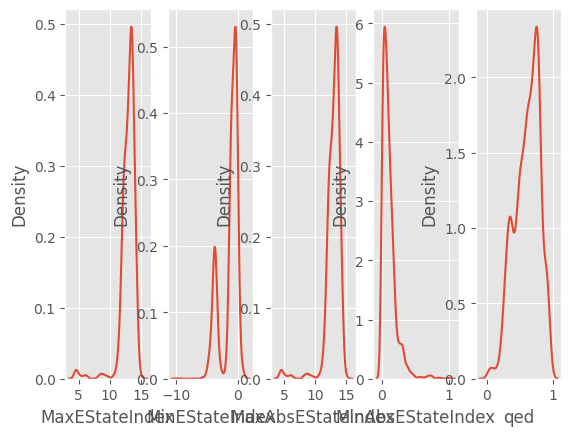

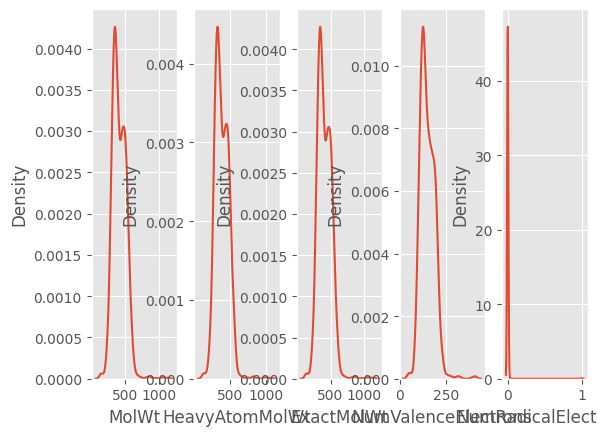

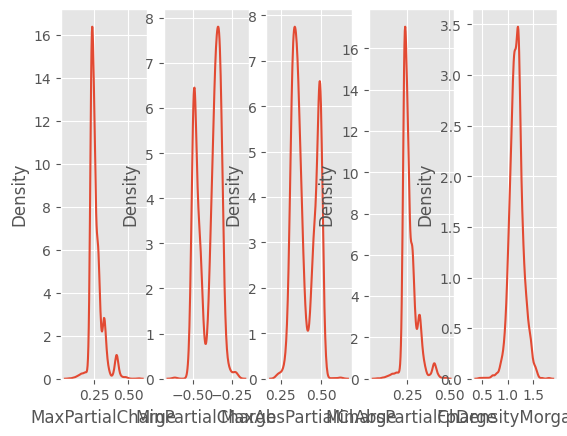

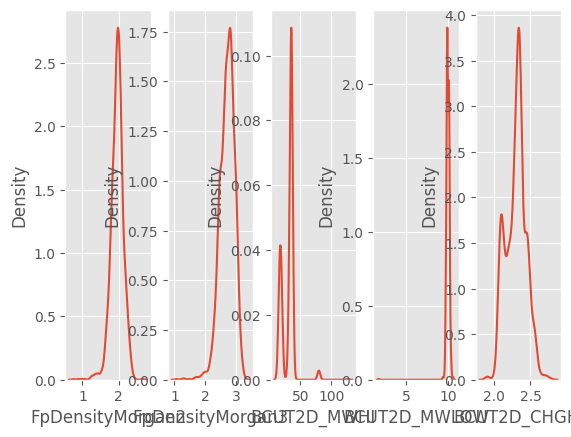

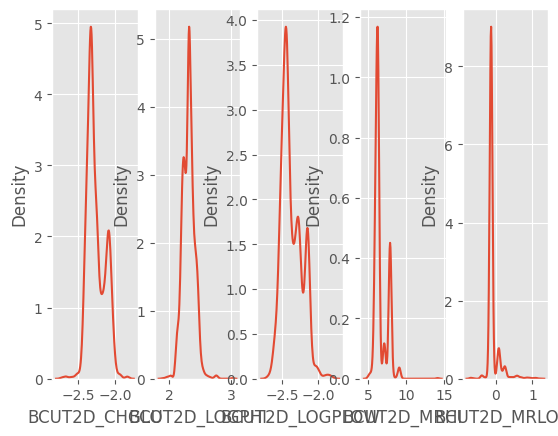

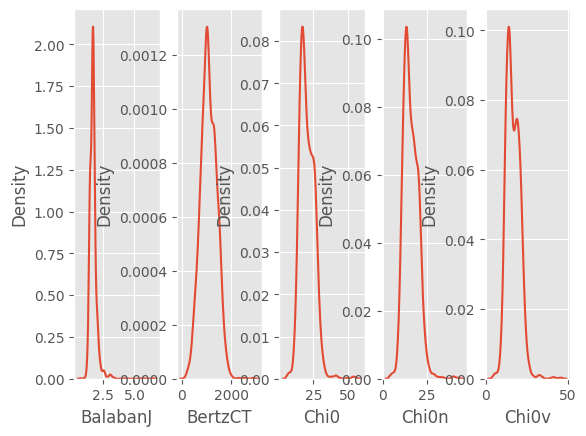

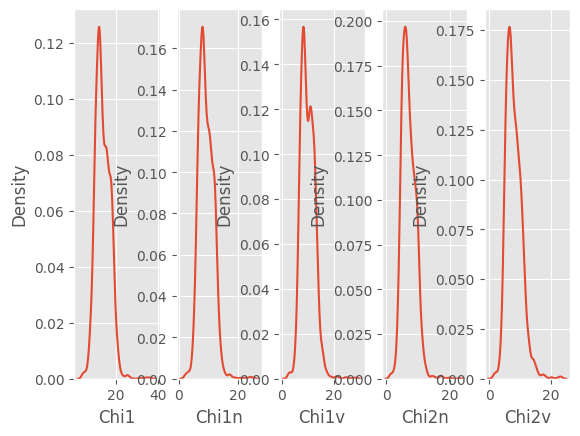

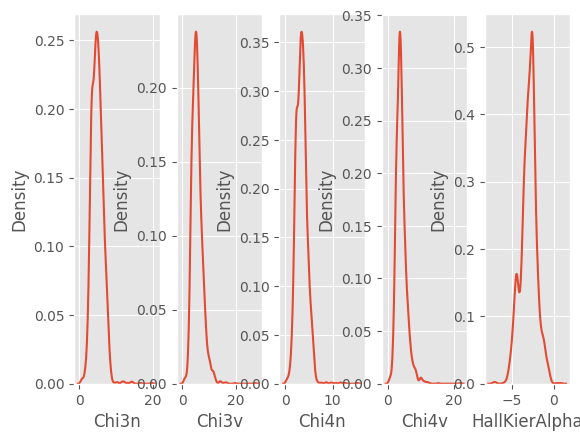

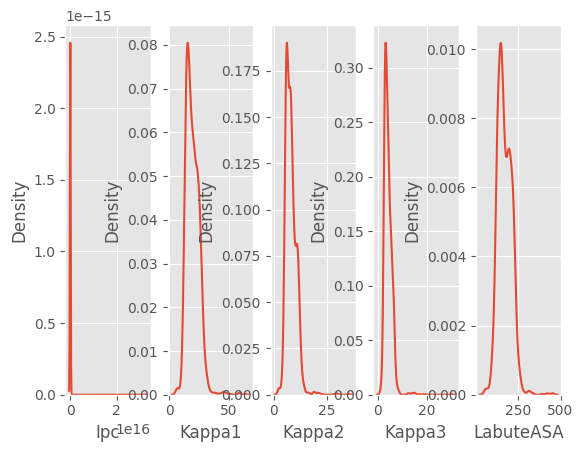

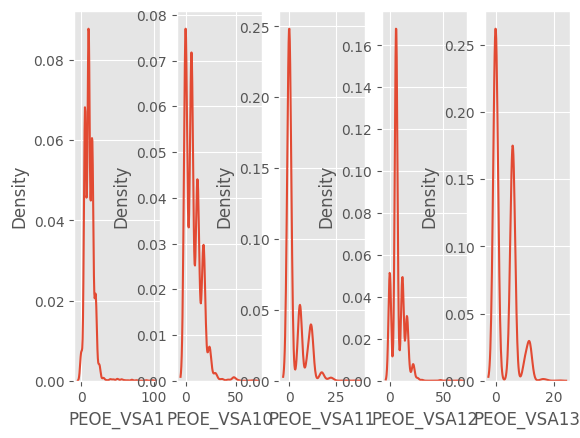

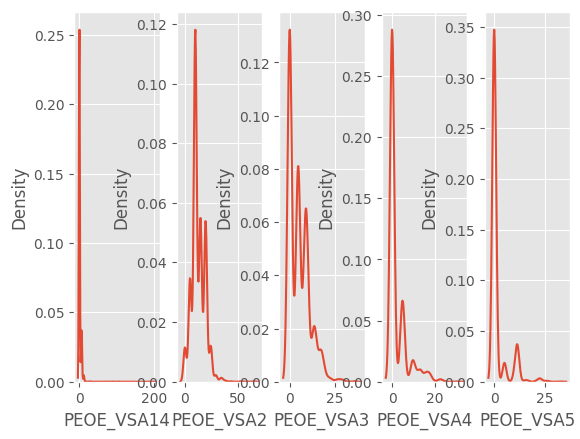

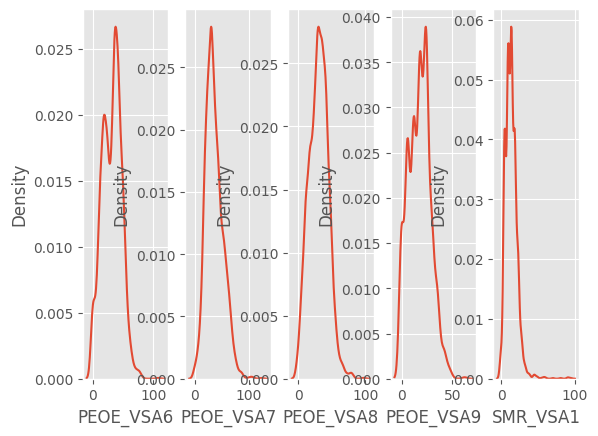

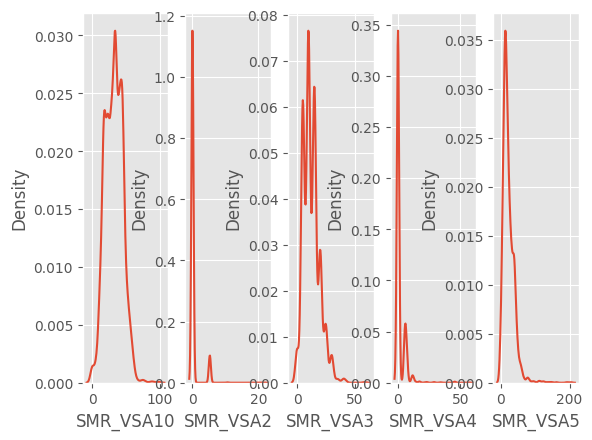

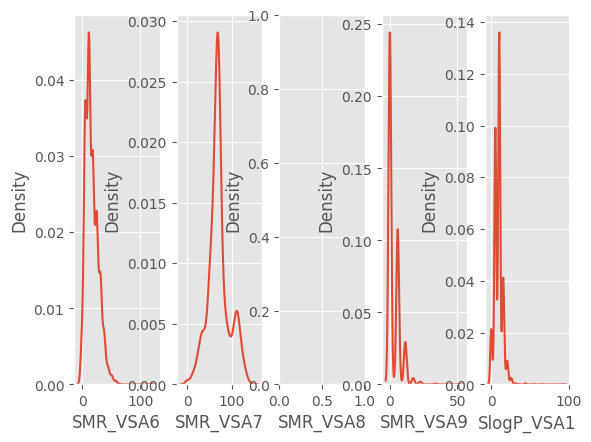

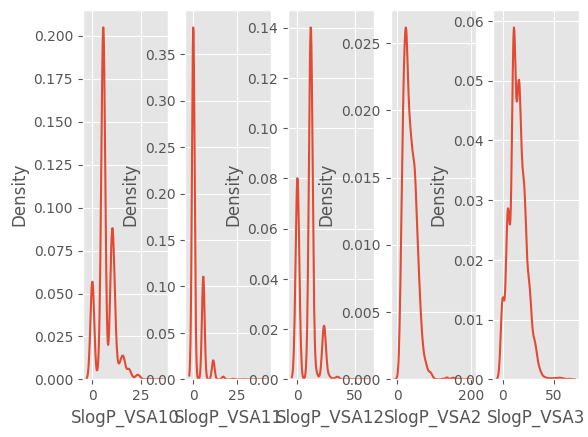

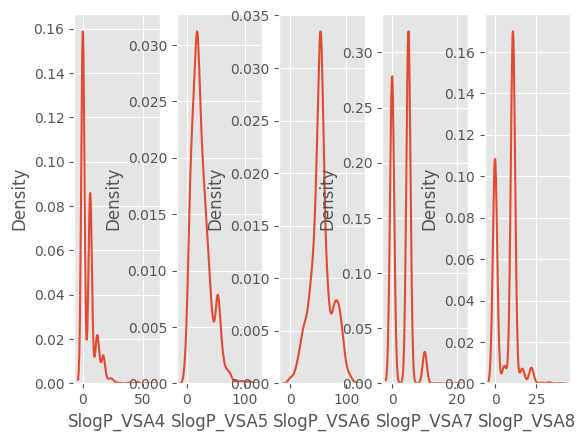

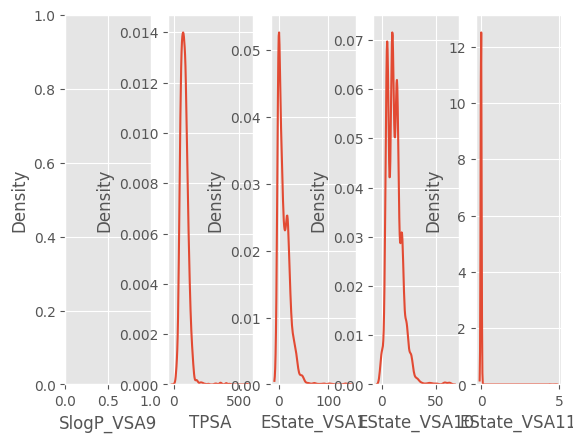

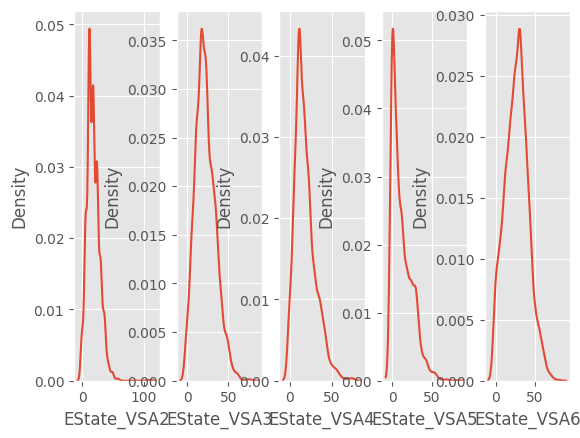

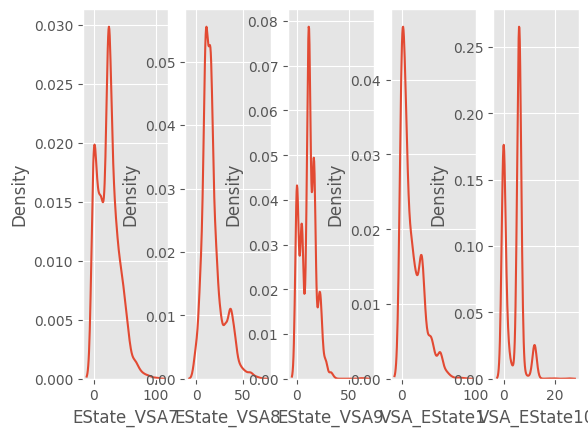

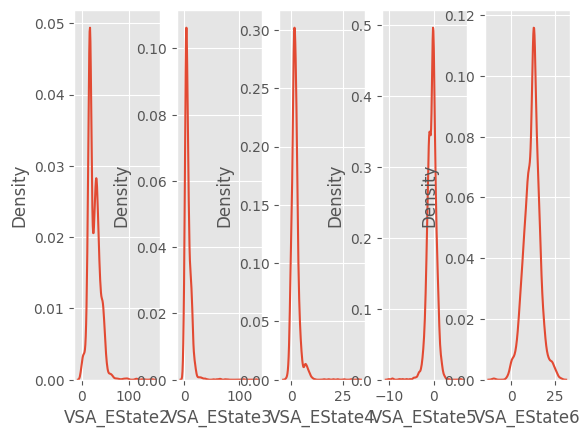

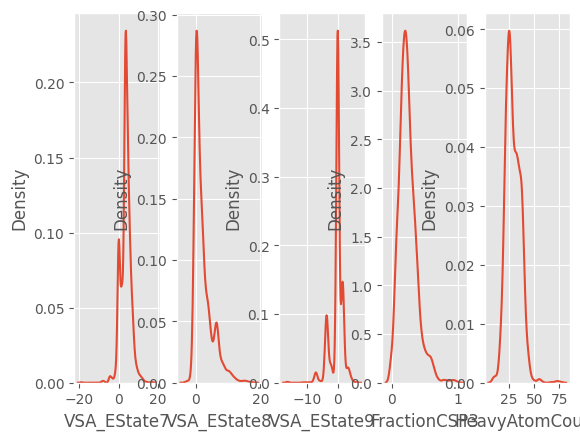

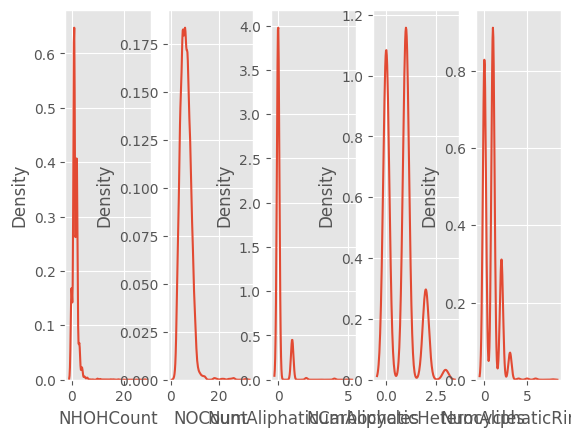

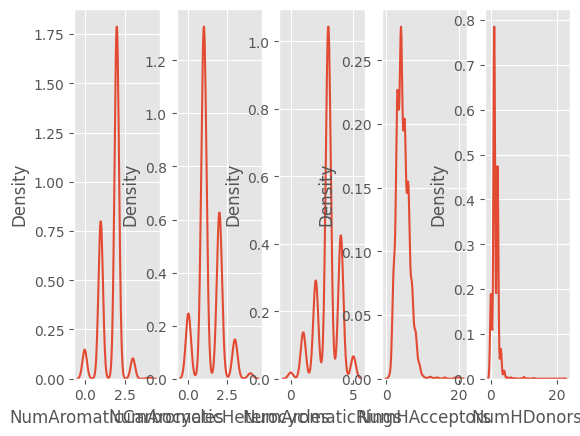

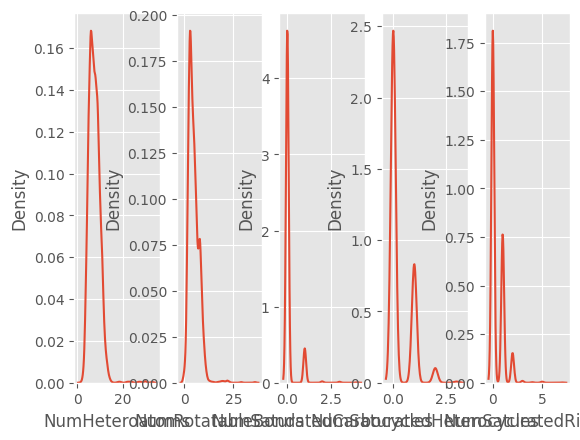

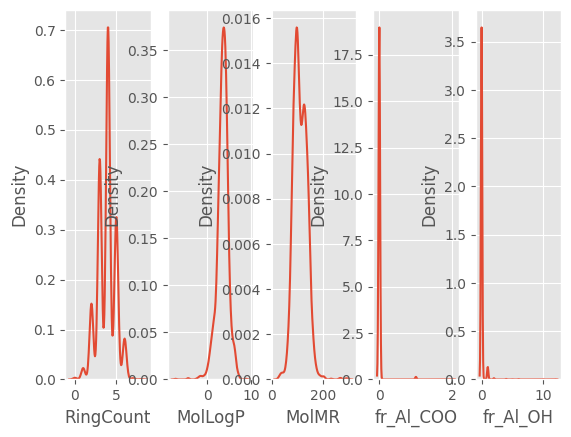

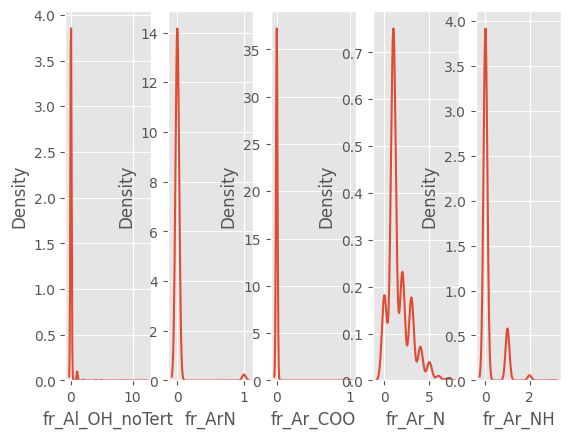

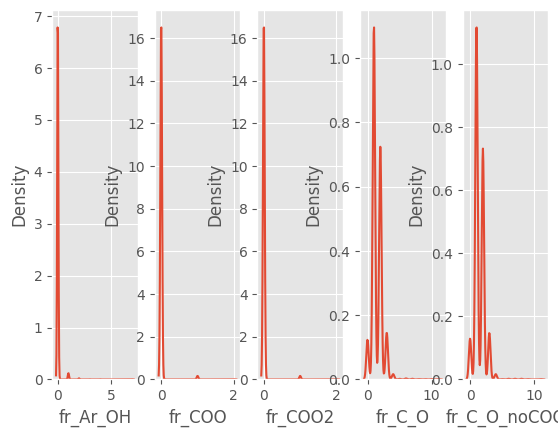

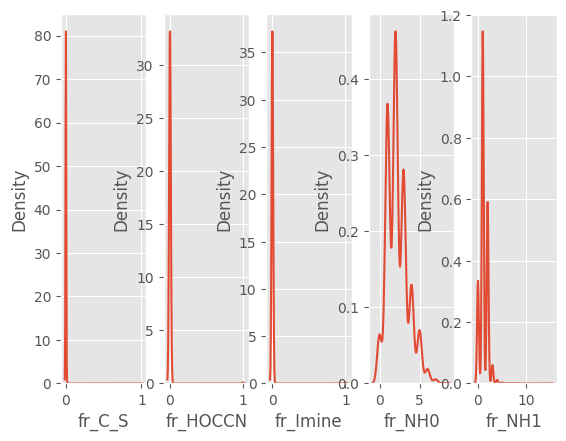

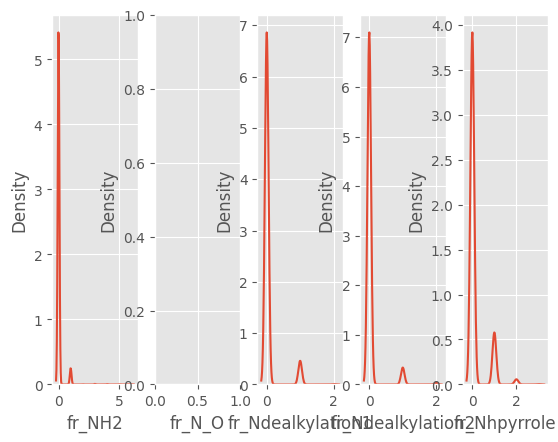

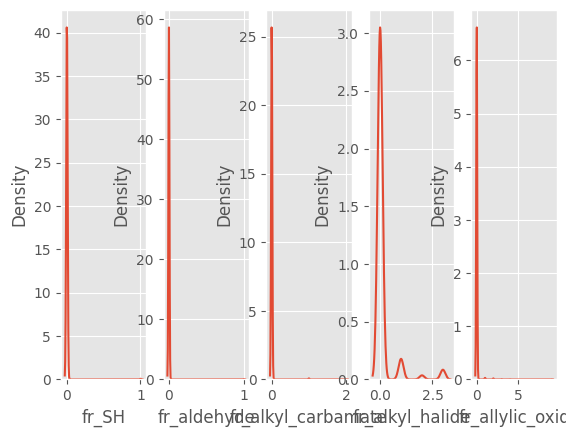

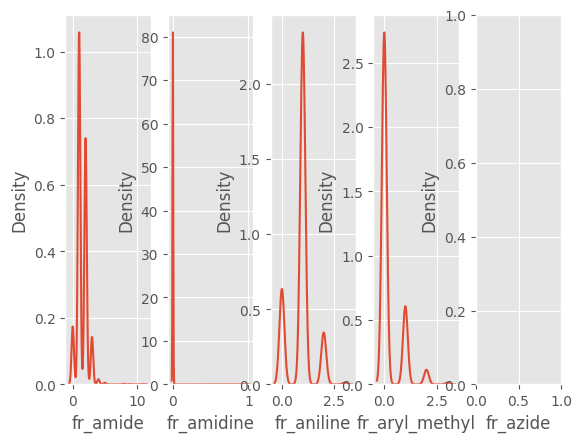

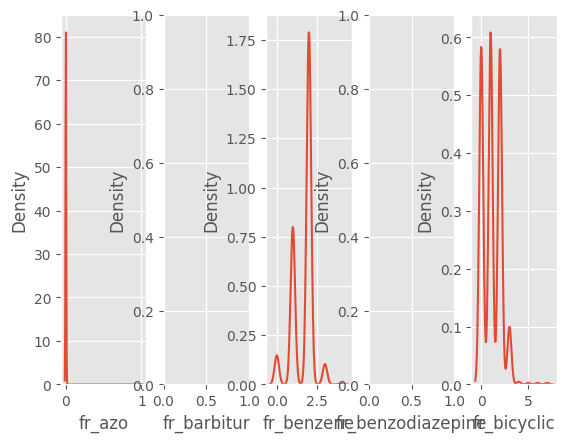

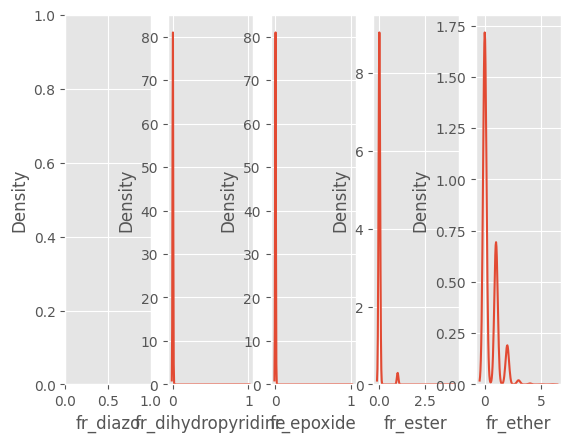

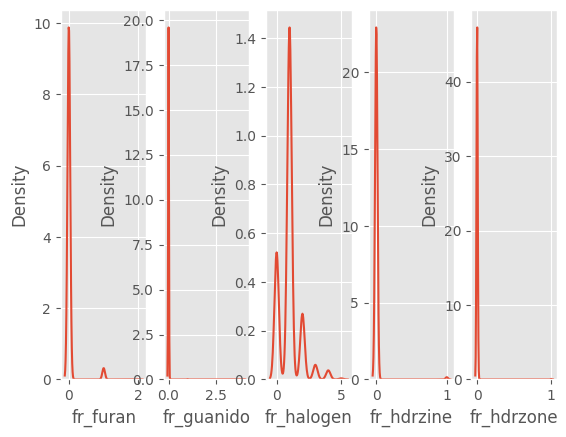

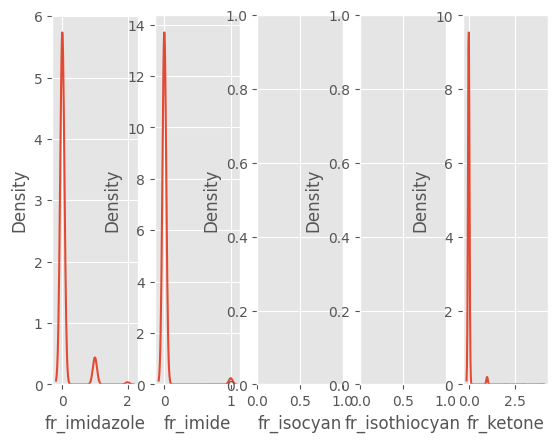

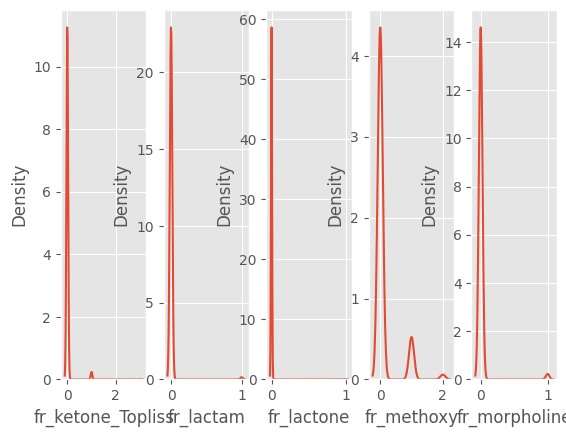

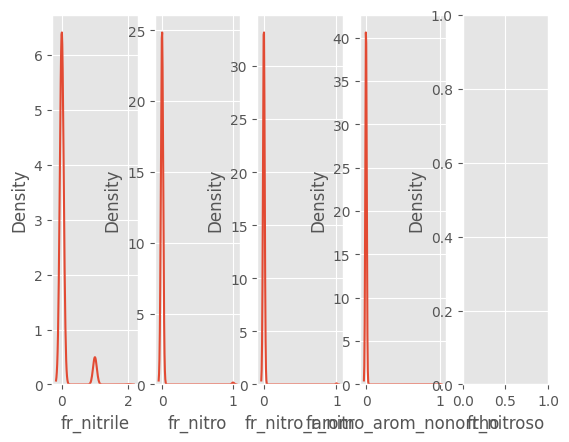

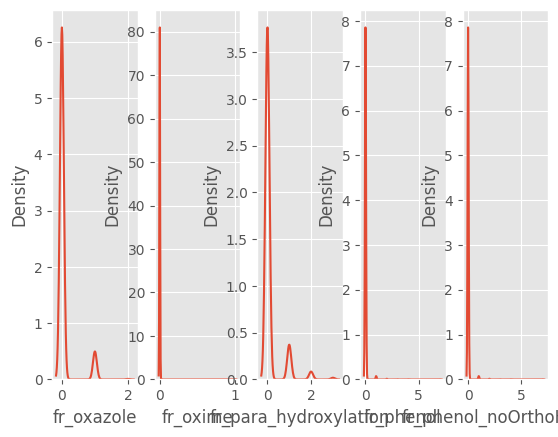

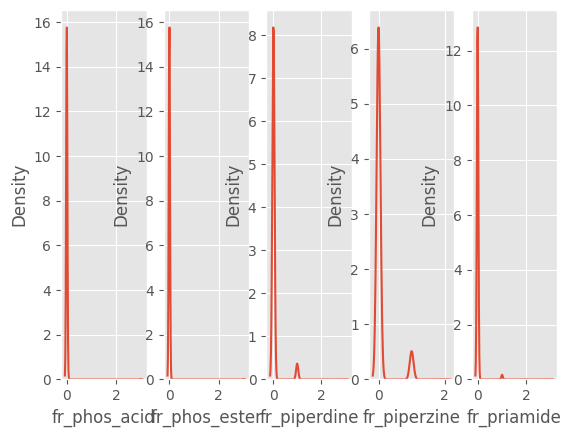

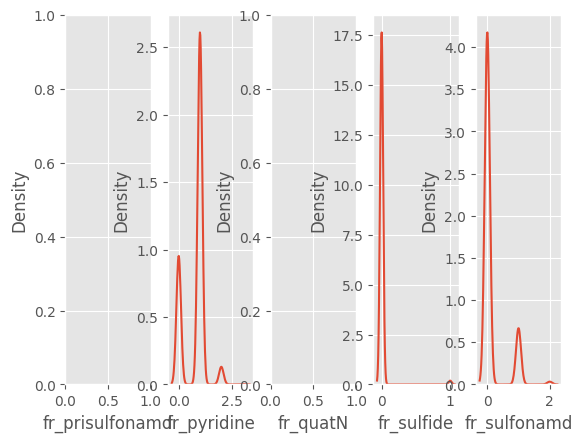

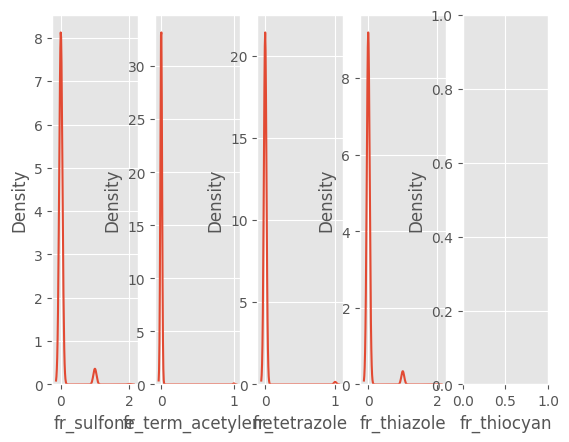

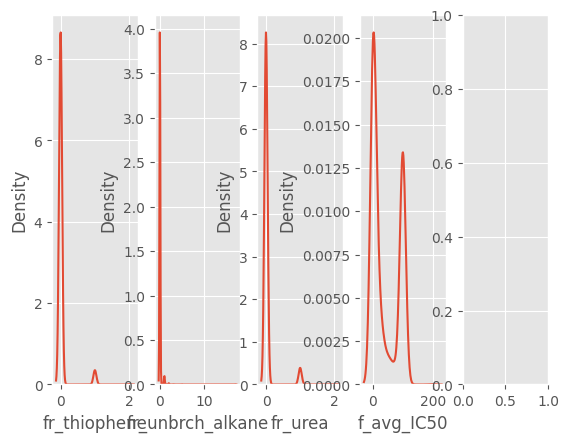

In [237]:
plotting_data = plotting_data.drop('SMILES', axis=1)
column_list = plotting_data.columns.values
print(column_list)

count = 0
while count < len(column_list):
    subset = plotting_data.iloc[:,count:count+5]
    fig, axs = plt.subplots(ncols=5)
    for i in range(0, 5):
        sns.kdeplot(subset[column_list[i+count]], ax=axs[i])
    count += 5

In [58]:
no_with_na = []
for i in column_list:
    na_q = plotting_data[i].isnull().values.any()
    if na_q:
        print(i)


MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
f_avg_IC50


In [314]:
print(len(np.where(plotting_data['f_avg_IC50'].isnull())[0]))

136


In [240]:
# so left with 136 rows with no IC50 values
# out of 2062 (based on above investigation of correlations between r and f IC50 measures we conclude that the best course of action will be to drop the entries with no f IC50 data in order that we are using a consistent measure of binding affinity)
print(len(plotting_data['f_avg_IC50']))

2062


In [315]:
rule_five_df = ligand_feature_df[['NumHDonors', 'NumHAcceptors', 'MolWt', 'MolLogP', 'f_avg_IC50']]
rule_five_df.head()

NumHDonors  NumHAcceptors    MolWt  MolLogP  f_avg_IC50
0         1.0            5.0  498.992   2.7033    0.275118
1         1.0            5.0  525.030   3.0934    0.202767
2         1.0            4.0  474.948   3.2973   55.453947
3         1.0            4.0  474.948   3.2973    0.050000
4         1.0            4.0  448.910   2.7647    0.052757

In [316]:
all_five = rule_five_df[(rule_five_df['NumHDonors'] <= 5) & (rule_five_df['NumHAcceptors'] <= 10) & (rule_five_df['MolWt'] < 500) & (rule_five_df['MolLogP'] <= 5)]
print(all_five.shape) # (1413,5)

(1539, 5)


In [317]:
index1 = rule_five_df[rule_five_df['NumHDonors'] > 5].index
index2 = rule_five_df[rule_five_df['NumHAcceptors'] > 10].index
index3 = rule_five_df[rule_five_df['MolWt'] >= 500].index
index4 = rule_five_df[rule_five_df['MolLogP'] > 5].index
index = list(index1) + list(index2) + list(index3) + list(index4)

In [318]:
violate_more_than_one = set()
count_index = defaultdict(int)
for number in index:
    count_index[number] = count_index[number]+1
    if count_index[number] >= 2:
        violate_more_than_one.add(number)

In [319]:
violate_no_more_than_one = rule_five_df[~rule_five_df.index.isin(list(violate_more_than_one))]#(1839, 5)
violate_no_more_than_one

NumHDonors  NumHAcceptors    MolWt  MolLogP  f_avg_IC50
0            1.0            5.0  498.992  2.70330    0.275118
1            1.0            5.0  525.030  3.09340    0.202767
2            1.0            4.0  474.948  3.29730   55.453947
3            1.0            4.0  474.948  3.29730    0.050000
4            1.0            4.0  448.910  2.76470    0.052757
...          ...            ...      ...      ...         ...
2057         2.0            3.0  272.695  3.25068   99.010000
2058         3.0            4.0  253.265  2.17948   54.272964
2059         3.0            3.0  277.287  3.07858   63.554925
2060         1.0            3.0  287.322  3.28768   26.719515
2061         1.0            2.0  262.312  3.41600   57.590417

[1974 rows x 5 columns]

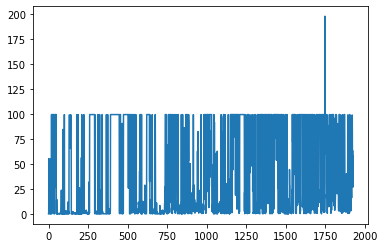

In [138]:
plt.plot(rule_five_df['f_avg_IC50']) #1926

In [1]:
plt.plot(sorted(list(rule_five_df['f_avg_IC50'])), 'r')

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/usr/local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/usr/local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

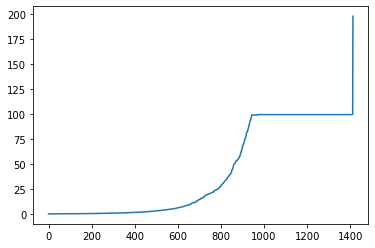

In [147]:
plt.plot(sorted(list(all_five['f_avg_IC50'])))

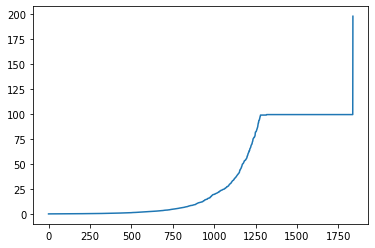

In [148]:
plt.plot(sorted(list(violate_no_more_than_one['f_avg_IC50'])))

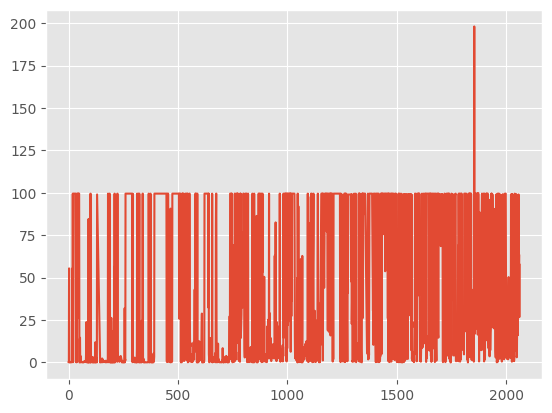

In [144]:
plt.plot(violate_no_more_than_one['f_avg_IC50'])#1839

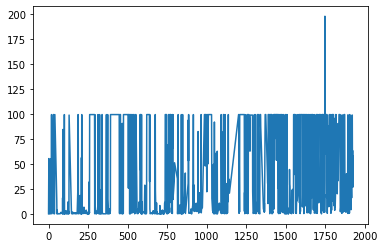

In [139]:
plt.plot(all_five['f_avg_IC50']) #1413

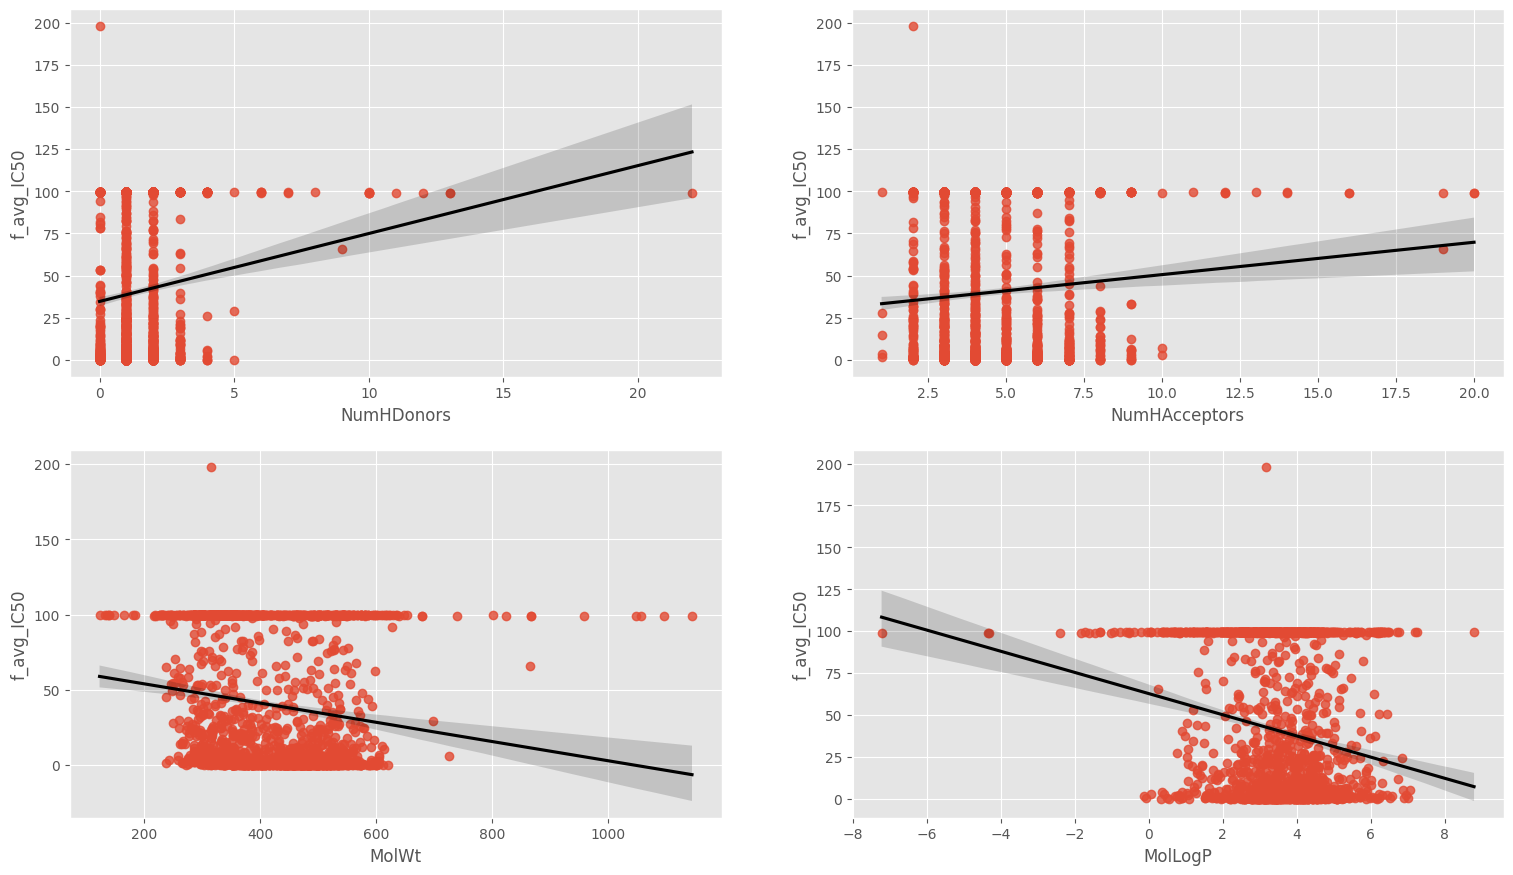

In [321]:
# plotting correlations between each feature and IC50

column_names = rule_five_df.columns.values

fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)

row_count = 0
col_count = 0
for i in range(0, 4):
    if i == 2:
        col_count = 0
        row_count = 1
    sns.regplot(x=rule_five_df[column_names[i]],  y=rule_five_df['f_avg_IC50'], ax=axs[row_count, col_count], line_kws={"color": "black"})
    #plt.legend(prop={'size': 10})
    #plt.title('Assay Comparison', fontsize = 15)
    ax=axs[row_count, col_count]
    #ax.xaxis.label(column_names[i], fontsize = 12)
    #ax.yaxis.label('IC50', fontsize = 12)
    #ax.xaxis.set_ticks(fontsize = 12)
    #ax.xaxis.set_ticks(fontsize = 12)
   
    
    col_count += 1

fig.savefig('../practical/rule_5_corr.pdf')


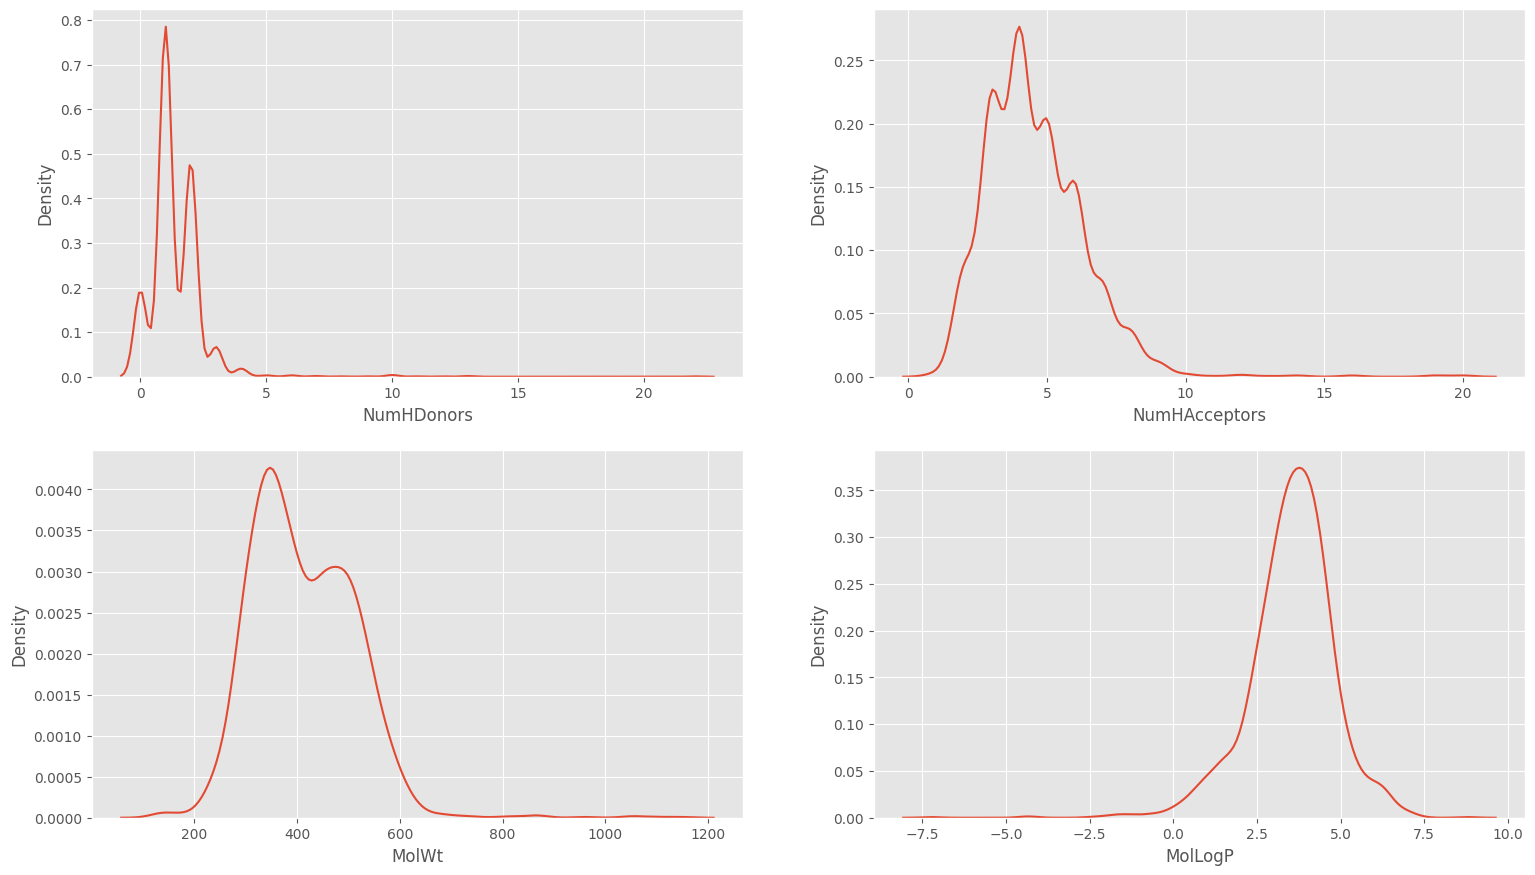

In [322]:
# plotting the distributions of each feature to check if any transformations are required
column_names = rule_five_df.columns.values

fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
row_count = 0
col_count = 0
for i in range(0, 4):
    if i == 2:
        col_count = 0
        row_count = 1
    sns.kdeplot(rule_five_df[column_names[i]], ax=axs[row_count, col_count])
    ax=axs[row_count, col_count]
    col_count += 1

fig.savefig('../practical/rule_5_dist.pdf')

In [ ]:
# what about when looking at the data without the cluster round 100?

In [323]:
# take violate no more than one and build a linear regression model
rule_five_df.dropna(inplace = True)
print(rule_five_df)

      NumHDonors  NumHAcceptors    MolWt  MolLogP  f_avg_IC50
0            1.0            5.0  498.992  2.70330    0.275118
1            1.0            5.0  525.030  3.09340    0.202767
2            1.0            4.0  474.948  3.29730   55.453947
3            1.0            4.0  474.948  3.29730    0.050000
4            1.0            4.0  448.910  2.76470    0.052757
...          ...            ...      ...      ...         ...
2057         2.0            3.0  272.695  3.25068   99.010000
2058         3.0            4.0  253.265  2.17948   54.272964
2059         3.0            3.0  277.287  3.07858   63.554925
2060         1.0            3.0  287.322  3.28768   26.719515
2061         1.0            2.0  262.312  3.41600   57.590417

[1926 rows x 5 columns]


/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_16802/3547182377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_five_df.dropna(inplace = True)


In [344]:

X = rule_five_df.drop('f_avg_IC50', axis=1)

y = rule_five_df['f_avg_IC50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

reg_model = sklearn.linear_model.LinearRegression()

reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test)

print(reg_model.score(X_test, y_test))  #0.103
print(mean_squared_error(y_test, predictions)) #1760
# score  = the coefficient of determination of the prediction

0.1166244090515578
1673.2497119998907


Training a linear model on the rule of 5 characteristics we obtain an accuracy of 0.12 and a mean squared error of 1673, not great...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


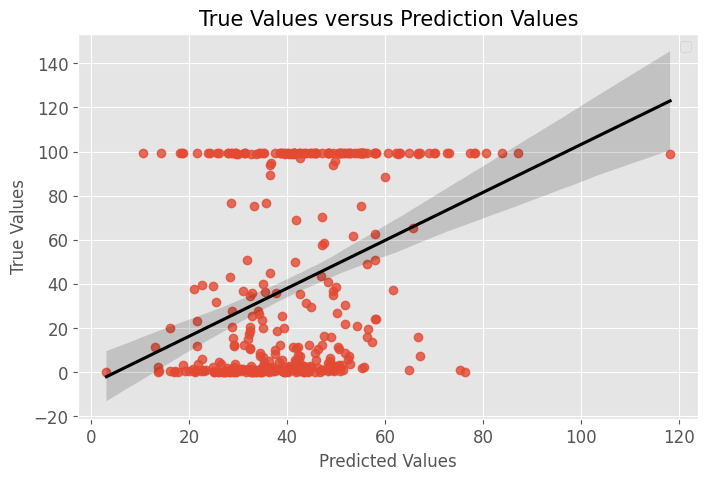

In [345]:
plt.figure(figsize=(8, 5))

# plot
sns.regplot(x=predictions, y=y_test, ci = 95, line_kws={'color': 'black'})
plt.legend(prop={'size': 10})
plt.title('True Values versus Prediction Values', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 12)
plt.ylabel('True Values', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)



# save figure
#plt.savefig('../Figure/Prediction versus True Plot.png', dpi = 300, bbox_inches='tight', facecolor='w')
plt.savefig('../practical/rule_5_linear')

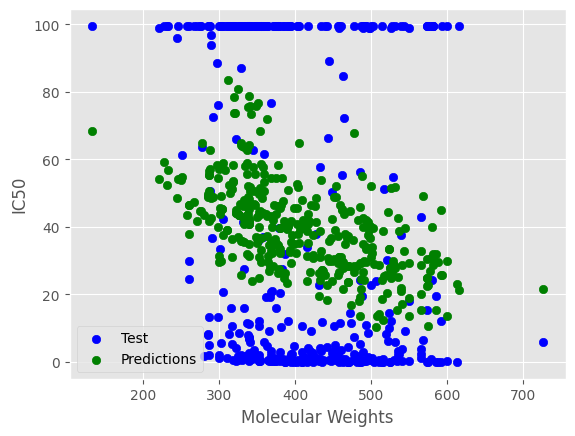

In [252]:
#x_vals = range(1, 396)
x_vals = X_test['MolWt']
plt.scatter(x_vals, y_test, color ='b')

plt.scatter(x_vals, predictions, color ='g')
plt.legend(['Test', 'Predictions'])
plt.xlabel('Molecular Weights')
plt.ylabel('IC50')
plt.show()

Text(0, 0.5, 'IC50')

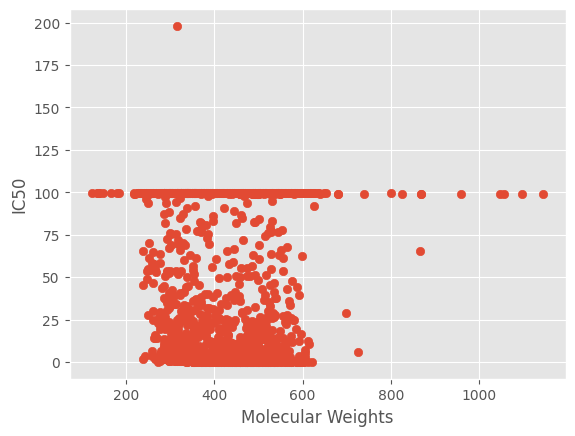

In [253]:
plt.scatter(rule_five_df['MolWt'], rule_five_df['f_avg_IC50'])
plt.xlabel('Molecular Weights')
plt.ylabel('IC50')

<AxesSubplot: xlabel='f_avg_IC50', ylabel='Density'>

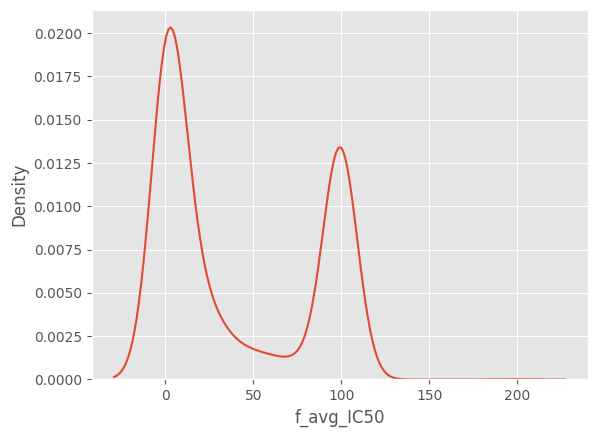

In [254]:
sns.kdeplot(rule_five_df['f_avg_IC50'])

In [342]:
scaled_IC50 = rule_five_df.copy()
scaled_IC50['pIC50'] = (-1)*np.log10(scaled_IC50['f_avg_IC50'])
#print(scaled_IC50['pIC50'])
#print(len(scaled_IC50['pIC50']))
#print((scaled_IC50['pIC50'].isna()))
#print(scaled_IC50['pIC50'])

scaled_IC50.dropna(inplace = True)
X = scaled_IC50.drop(['f_avg_IC50', 'pIC50'], axis=1)
print(len(X))
y = scaled_IC50['pIC50']
#print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

reg_model2 = sklearn.linear_model.LinearRegression()

reg_model2.fit(X_train, y_train)

predictions2 = reg_model2.predict(X_test)

print(reg_model2.score(X_test, y_test))  #0.149
print(mean_squared_error(y_test, predictions2)) #0.894
# score  = the coefficient of determination of the prediction

1926
0.12597036219447189
0.8903527125345312


So based on the distribution and the log transformation having the effect of smoothing, we repeat the linear model on the transformed data. Obtaining a score of 0.13 and mean squared error of 0.89

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


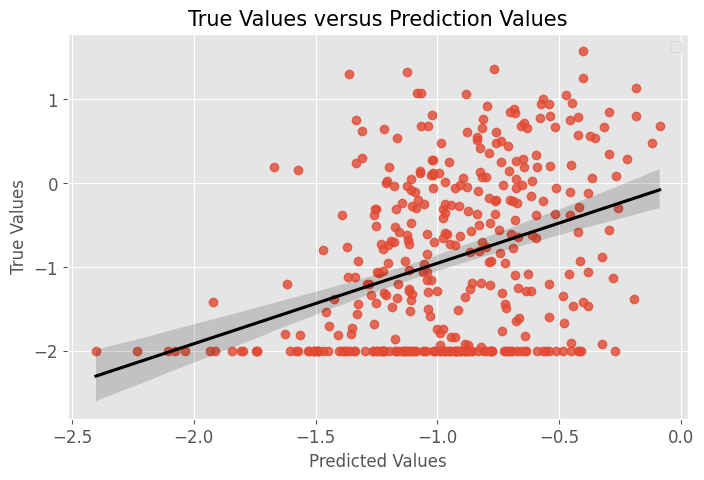

In [343]:
plt.figure(figsize=(8, 5))

# plot
sns.regplot(x=predictions2, y=y_test, ci = 95, line_kws={'color': 'black'})
plt.legend(prop={'size': 10})
plt.title('True Values versus Prediction Values', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 12)
plt.ylabel('True Values', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)



# save figure
#plt.savefig('../Figure/Prediction versus True Plot.png', dpi = 300, bbox_inches='tight', facecolor='w')
plt.savefig('../practical/rule_5_linear_scale.pdf')

But the data before looked like it had two peaks, low affinity and high affinity, this could impact how we select test and training, if there is a big imbalance, but also suggests classification might work on IC50.

In [331]:
high_affinity = rule_five_df[rule_five_df['f_avg_IC50'] < 50]
low_affinity = rule_five_df[rule_five_df['f_avg_IC50'] >= 50]

print(len(high_affinity['f_avg_IC50']))
print(len(low_affinity['f_avg_IC50']))

1204
722


1204 high and 722 low. Not a huge amount of difference so we proceed selecting testing and training at random.

In [332]:
classification_data = rule_five_df.copy()
classification_data['high_low_binder'] = np.where(classification_data['f_avg_IC50'] < 50, 'High', 'Low')

X = classification_data.drop(['f_avg_IC50', 'high_low_binder'], axis=1)

y = classification_data['high_low_binder']

classification_data.dropna(inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

logistic_model = sklearn.linear_model.LogisticRegression()

logistic_model.fit(X_train, y_train)

log_predictions = logistic_model.predict(X_test)

print(logistic_model.score(X_test, y_test)) # 0.671
cm = sklearn.metrics.confusion_matrix(y_test, log_predictions)

0.6787564766839378


We take 50 nM as the cut off based on the distribution and a quick scan of the literature where similar cutoffs tend to be used. Fitting a logistic regression model we obtain a score of 0.68.

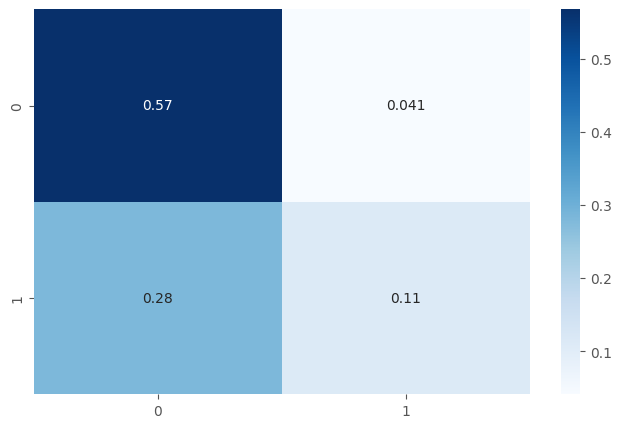

In [334]:
plt.figure(figsize=(8, 5))
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')
plt.savefig('../practical/log_model_confusion_matrix.pdf')

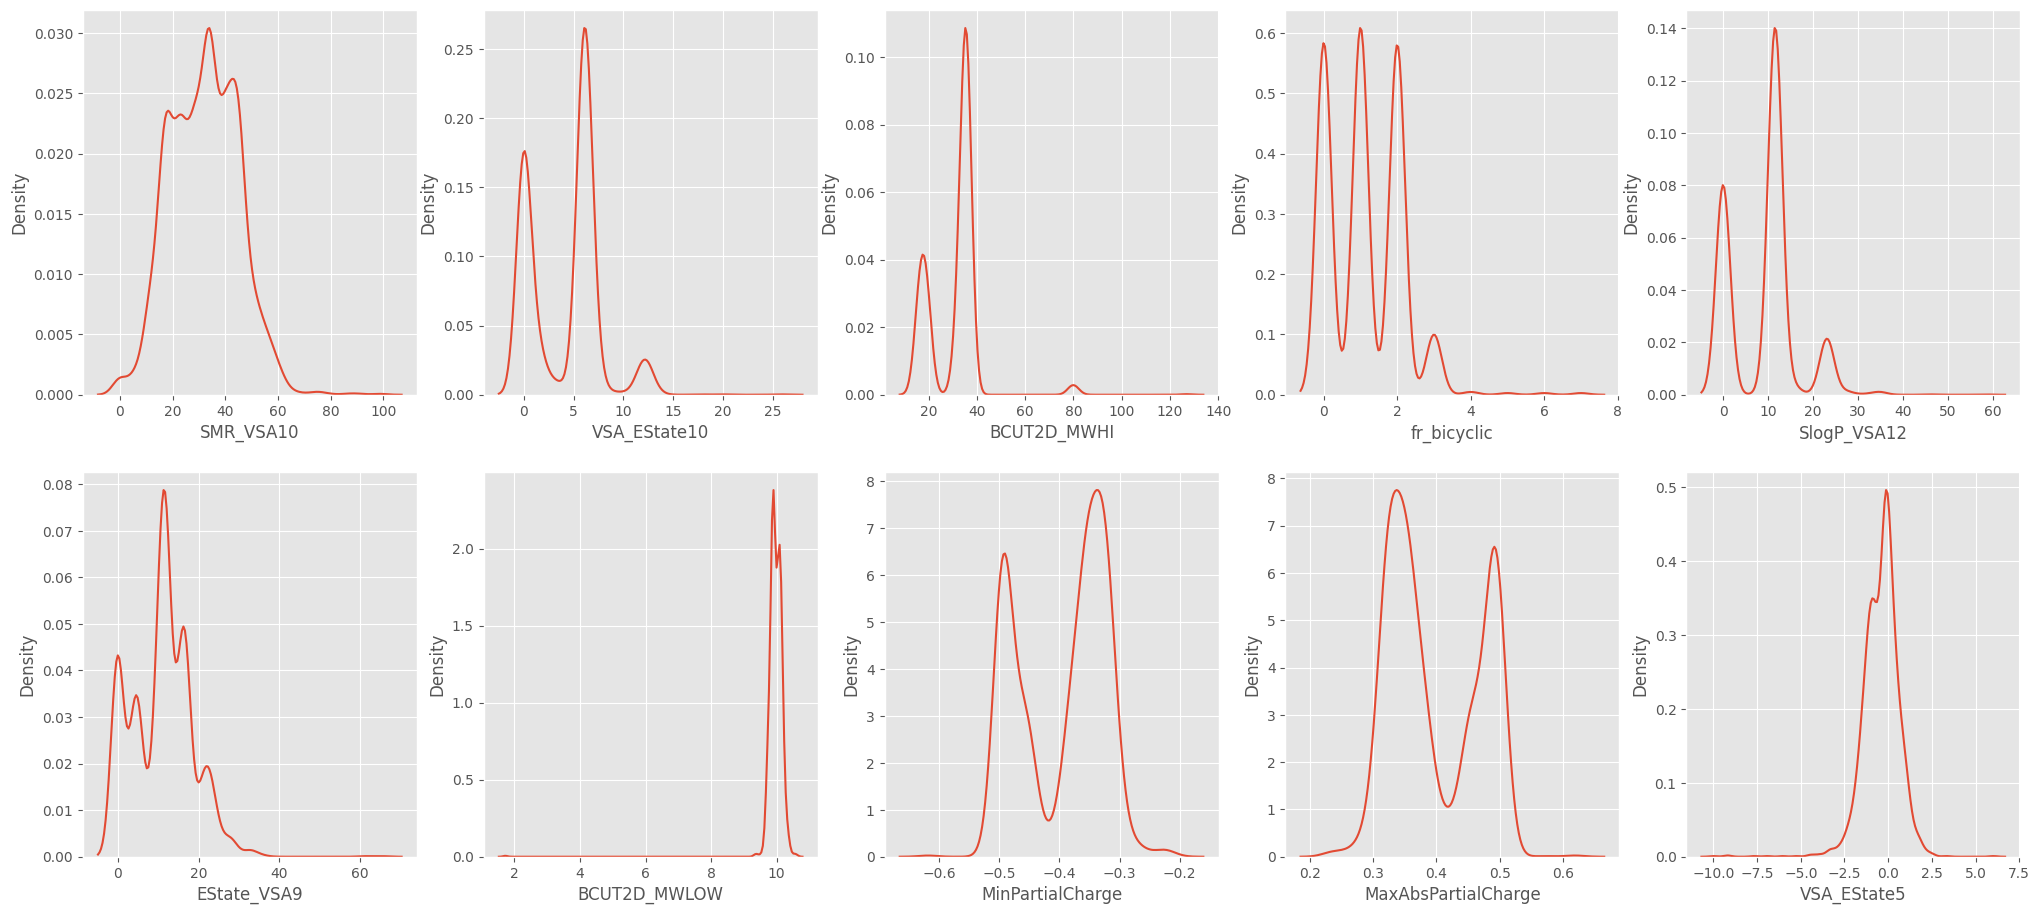

In [335]:
# density plots of most important features:
top_features = ligand_feature_df[['SMR_VSA10', 'VSA_EState10', 'BCUT2D_MWHI', 'fr_bicyclic', 'SlogP_VSA12', 'EState_VSA9', 'BCUT2D_MWLOW', 'MinPartialCharge', 'MaxAbsPartialCharge', 'VSA_EState5']]
column_names = top_features.columns.values

fig, axs = plt.subplots(2,5)
fig.set_size_inches(25, 11)
row_count = 0
col_count = 0
for i in range(0, 10):
    if i == 5:
        col_count = 0
        row_count = 1
    sns.kdeplot(top_features[column_names[i]], ax=axs[row_count, col_count])
    col_count += 1

plt.savefig('../practical/top_features_dist.pdf')
    

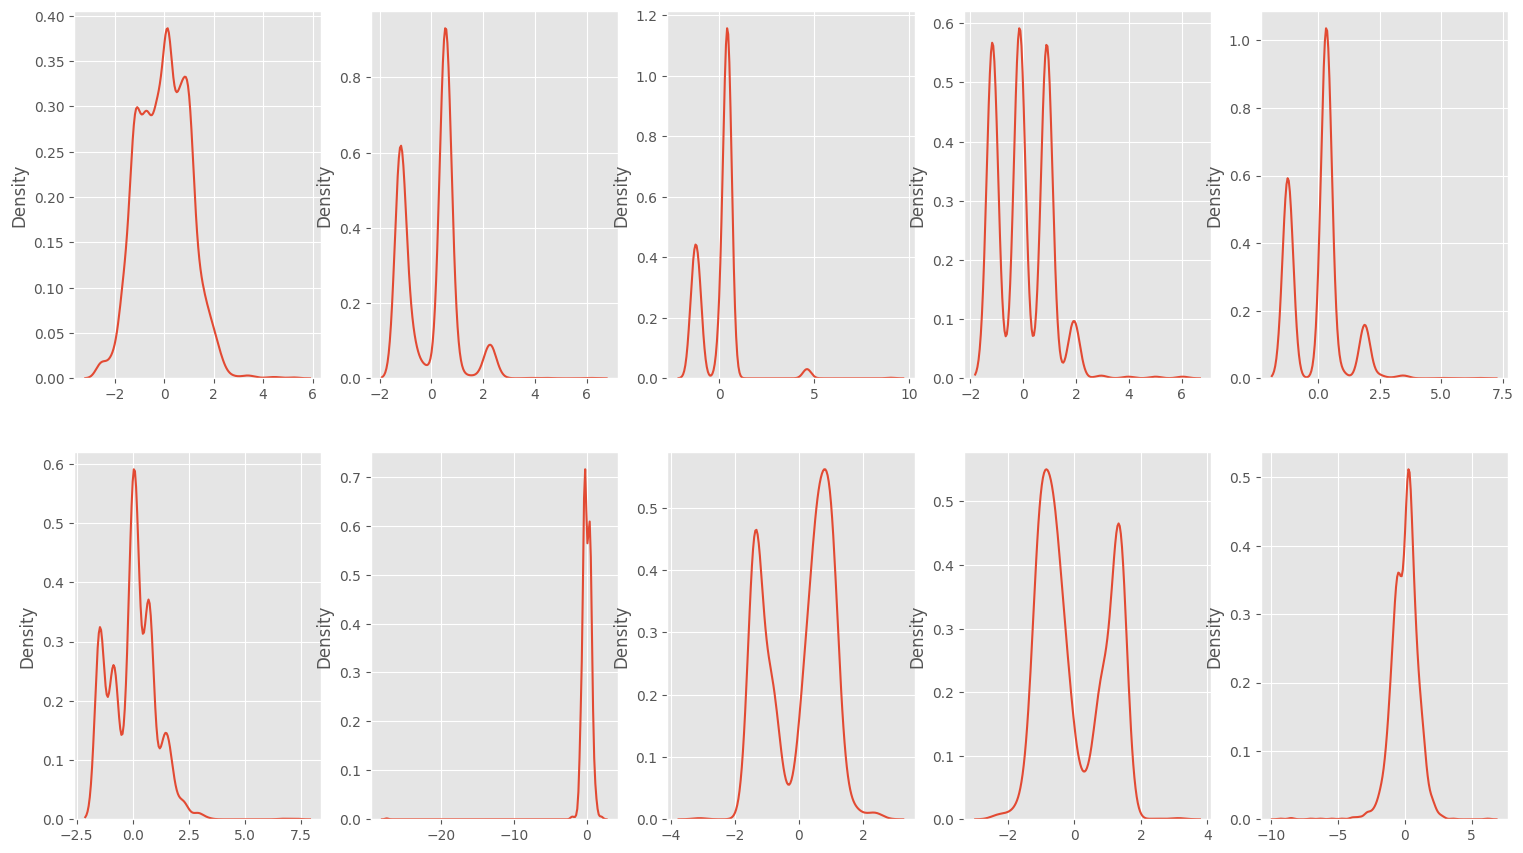

In [265]:
# normalise most important features and then plot
top_features = ligand_feature_df[['SMR_VSA10', 'VSA_EState10', 'BCUT2D_MWHI', 'fr_bicyclic', 'SlogP_VSA12', 'EState_VSA9', 'BCUT2D_MWLOW', 'MinPartialCharge', 'MaxAbsPartialCharge', 'VSA_EState5']]
column_names = top_features.columns.values

fig, axs = plt.subplots(2,5)
fig.set_size_inches(18.5, 10.5)
row_count = 0
col_count = 0
for i in range(0, 10):
    data = top_features[column_names[i]]
    data.dropna
    normalized_arr = sklearn.preprocessing.scale(data)
    if i == 5:
        col_count = 0
        row_count = 1
    sns.kdeplot(normalized_arr, ax=axs[row_count, col_count])
    col_count += 1

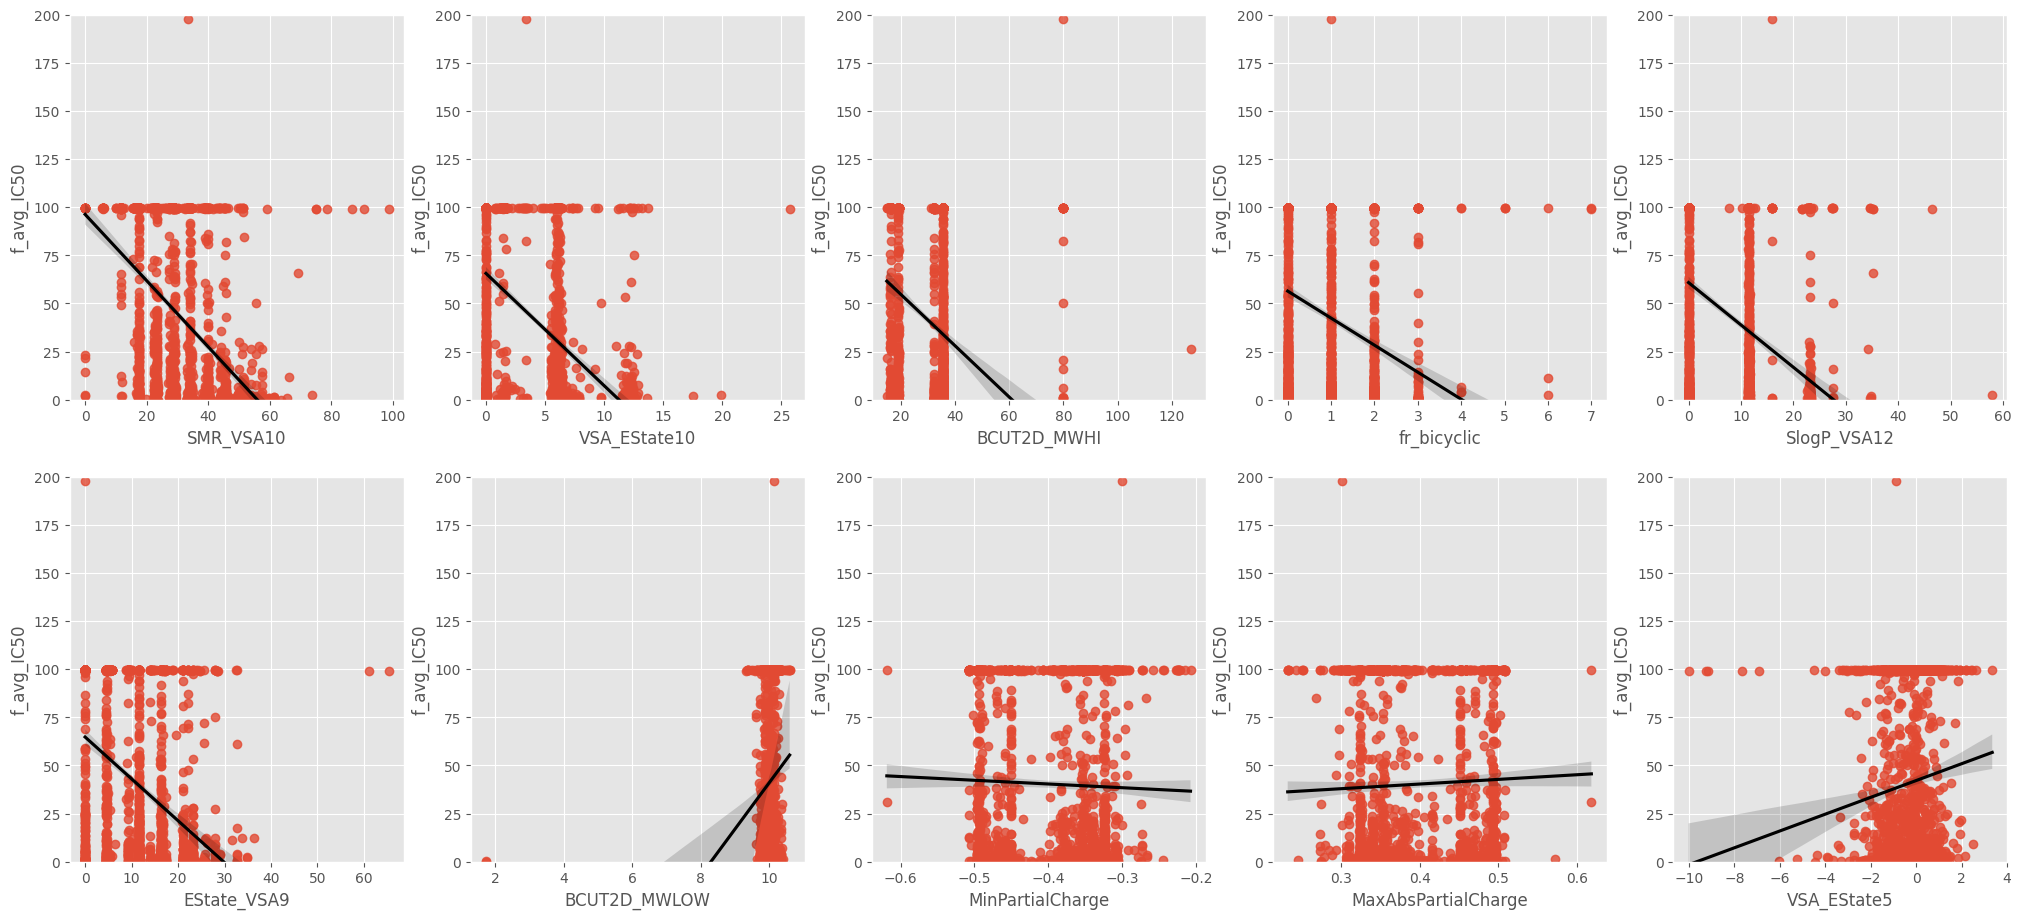

In [336]:
# plotting these top features against IC50

fig, axs = plt.subplots(2,5)
fig.set_size_inches(25, 11)
row_count = 0
col_count = 0
for i in range(0, 10):
    if i == 5:
        col_count = 0
        row_count = 1
    sns.regplot(x=top_features[column_names[i]],  y=ligand_feature_df['f_avg_IC50'], ax=axs[row_count, col_count], line_kws={"color": "black"})
    ax = axs[row_count, col_count]
    ax.set_ylim(0,200)
    col_count += 1

plt.savefig('../practical/top_features_corr.pdf')

What if we now returned to a simple linear model using these features which performed well in the random forest?

In [337]:
# A top feature based linear regression model:

top_features = ligand_feature_df[['SMR_VSA10', 'VSA_EState10', 'BCUT2D_MWHI', 'fr_bicyclic', 'SlogP_VSA12', 'EState_VSA9', 'BCUT2D_MWLOW', 'MinPartialCharge', 'MaxAbsPartialCharge', 'VSA_EState5', 'f_avg_IC50']]

top_features['pIC50'] = (-1)*np.log10(top_features['f_avg_IC50'])
#print(scaled_IC50['pIC50'])
#print(len(scaled_IC50['pIC50']))
#print((scaled_IC50['pIC50'].isna()))
#print(len(top_features['pIC50']))

top_features.dropna(inplace = True)
X = top_features.drop(['f_avg_IC50', 'pIC50'], axis=1)
#print(len(X))
y = top_features['pIC50']
#print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

reg_model_top = sklearn.linear_model.LinearRegression()

reg_model_top.fit(X_train, y_train)

predictions_top = reg_model_top.predict(X_test)

print(reg_model_top.score(X_test, y_test))  #0.3822
print(mean_squared_error(y_test, predictions_top)) #0.726


0.42337596583634163
0.6412277502838096


/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_16802/891889830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['pIC50'] = (-1)*np.log10(top_features['f_avg_IC50'])
/var/folders/l5/vvvd6vv53p5c2fcx_mh240dw0000gn/T/ipykernel_16802/891889830.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features.dropna(inplace = True)


We get a score of 0.42 anda mean squared error of 0.64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


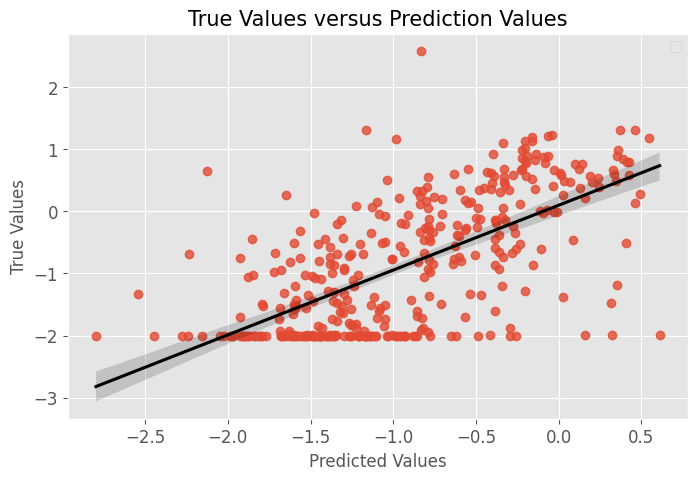

In [341]:
plt.figure(figsize=(8, 5))

# plot
sns.regplot(x=predictions_top, y=y_test, ci = 95, line_kws={'color': 'black'})
plt.legend(prop={'size': 10})
plt.title('True Values versus Prediction Values', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 12)
plt.ylabel('True Values', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)



# save figure
#plt.savefig('../Figure/Prediction versus True Plot.png', dpi = 300, bbox_inches='tight', facecolor='w')
plt.savefig('../practical/top_featues_linear.pdf')